In [1]:
# coding: utf-8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

from mydatools.plot import plot_grid_search_result

% matplotlib inline

In [2]:
train_df = pd.read_csv('./data/input/train.csv')
test_df = pd.read_csv('./data/input/test.csv')
full_df = pd.concat([train_df, test_df], keys=['train', 'test'])
del(train_df)
del(test_df)
full_df.head()

dropoff_datetime  dropoff_latitude  dropoff_longitude         id  \
train 0  2016-03-14 17:32:30         40.765602         -73.964630  id2875421   
      1  2016-06-12 00:54:38         40.731152         -73.999481  id2377394   
      2  2016-01-19 12:10:48         40.710087         -74.005333  id3858529   
      3  2016-04-06 19:39:40         40.706718         -74.012268  id3504673   
      4  2016-03-26 13:38:10         40.782520         -73.972923  id2181028   

         passenger_count      pickup_datetime  pickup_latitude  \
train 0                1  2016-03-14 17:24:55        40.767937   
      1                1  2016-06-12 00:43:35        40.738564   
      2                1  2016-01-19 11:35:24        40.763939   
      3                1  2016-04-06 19:32:31        40.719971   
      4                1  2016-03-26 13:30:55        40.793209   

         pickup_longitude store_and_fwd_flag  trip_duration  vendor_id  
train 0        -73.982155                  N          455.0          2  
      1        -73.980415                  N          663.0          1  
      2        -73.979027                  N         2124.0          2  
      3        -74.010040                  N          429.0          2  
      4        -73.973053                  N          435.0          2

In [3]:
full_df['log1p_trip_duration'] = np.log1p(full_df['trip_duration'])

## feature

In [4]:
feature_columns = [
    'passenger_count', 'vendor_id',
    'store_and_fwd_flag',
    'pickup_latitude', 'pickup_longitude',
#     'dropoff_latitude', 'dropoff_longitude', # 注意 这个不能用 这个是结果的一个信息
]

In [5]:
def add_features(features):
    if type(features) != list:
        features = [features]
    global feature_columns
    feature_columns.extend([f for f in features if f not in feature_columns])

In [6]:
full_df['store_and_fwd_flag'] = full_df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

* generate basic features

In [7]:
def gen_feature(prefix):
    # datetime features
    f_datetime = prefix + '_datetime'
    attr_list = ['year', 'month', 'day', 'dayofweek', 'minute']

    full_df[f_datetime] = pd.to_datetime(full_df[f_datetime])
    for attr in attr_list:
        full_df[prefix+'_'+attr] = eval("full_df[f_datetime].dt."+attr)
        add_features(prefix+'_'+attr)

gen_feature('pickup')
# gen_feature('dropoff')

* riding distance

In [8]:
get_distance = lambda x1, y1, x2, y2: np.sqrt((x1-x2)**2 + (y1-y2)**2)
full_df['distance'] = get_distance(full_df['pickup_latitude'], full_df['dropoff_latitude'], full_df['pickup_longitude'], full_df['dropoff_longitude'])
add_features('distance')

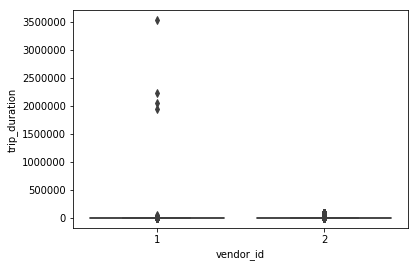

In [9]:
sns.boxplot('vendor_id', 'trip_duration', data=full_df)

## 预处理

In [10]:
trn_df = full_df.loc['train']
tst_df = full_df.loc['test']

X = trn_df[feature_columns].values
y = trn_df['log1p_trip_duration'].values
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_tst = tst_df[feature_columns].values
# y_tst = tst_df['log1p_trip_duration'].values

trn_lgb = lgb.Dataset(X_trn, y_trn)
val_lgb = lgb.Dataset(X_val, y_val, reference=trn_lgb)

## LightGBM

In [22]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.15,
#     'max_depth': 5,
#     'num_leaves': 20,
#     'subsample': 0.8,
#     'colsample_bytree': 0.5,
#     'min_child_weight': 3, 
#     'min_child_samples': 6,
#     'reg_alpha': 0.01,
    'verbose': 1,
    'seed': 0,
}
bst = lgb.train(params, trn_lgb, 500, valid_sets=[trn_lgb, val_lgb], early_stopping_rounds=20)

[1]	training's rmse: 0.774099	valid_1's rmse: 0.771868
Train until valid scores didn't improve in 20 rounds.
[2]	training's rmse: 0.757844	valid_1's rmse: 0.755584
[3]	training's rmse: 0.745269	valid_1's rmse: 0.742968
[4]	training's rmse: 0.735719	valid_1's rmse: 0.733338
[5]	training's rmse: 0.728692	valid_1's rmse: 0.726315
[6]	training's rmse: 0.72332	valid_1's rmse: 0.720914
[7]	training's rmse: 0.718633	valid_1's rmse: 0.716153
[8]	training's rmse: 0.714501	valid_1's rmse: 0.712019
[9]	training's rmse: 0.712106	valid_1's rmse: 0.709624
[10]	training's rmse: 0.709951	valid_1's rmse: 0.707426
[11]	training's rmse: 0.708367	valid_1's rmse: 0.705829
[12]	training's rmse: 0.707171	valid_1's rmse: 0.704621
[13]	training's rmse: 0.706092	valid_1's rmse: 0.703523
[14]	training's rmse: 0.705133	valid_1's rmse: 0.702511
[15]	training's rmse: 0.703479	valid_1's rmse: 0.700865
[16]	training's rmse: 0.702494	valid_1's rmse: 0.699926
[17]	training's rmse: 0.701756	valid_1's rmse: 0.699177
[18]

[152]	training's rmse: 0.684471	valid_1's rmse: 0.68461
[153]	training's rmse: 0.684428	valid_1's rmse: 0.684583
[154]	training's rmse: 0.684382	valid_1's rmse: 0.684588
[155]	training's rmse: 0.684311	valid_1's rmse: 0.684536
[156]	training's rmse: 0.68429	valid_1's rmse: 0.684534
[157]	training's rmse: 0.684264	valid_1's rmse: 0.684525
[158]	training's rmse: 0.68422	valid_1's rmse: 0.684488
[159]	training's rmse: 0.68417	valid_1's rmse: 0.68444
[160]	training's rmse: 0.684116	valid_1's rmse: 0.684399
[161]	training's rmse: 0.68408	valid_1's rmse: 0.684376
[162]	training's rmse: 0.684042	valid_1's rmse: 0.684349
[163]	training's rmse: 0.684014	valid_1's rmse: 0.684335
[164]	training's rmse: 0.683925	valid_1's rmse: 0.684283
[165]	training's rmse: 0.683834	valid_1's rmse: 0.684228
[166]	training's rmse: 0.683787	valid_1's rmse: 0.684212
[167]	training's rmse: 0.683775	valid_1's rmse: 0.684214
[168]	training's rmse: 0.68374	valid_1's rmse: 0.684215
[169]	training's rmse: 0.683727	valid_

[298]	training's rmse: 0.680266	valid_1's rmse: 0.683118
[299]	training's rmse: 0.680236	valid_1's rmse: 0.683102
[300]	training's rmse: 0.680209	valid_1's rmse: 0.683089
[301]	training's rmse: 0.680188	valid_1's rmse: 0.683083
[302]	training's rmse: 0.680166	valid_1's rmse: 0.683082
[303]	training's rmse: 0.680141	valid_1's rmse: 0.683077
[304]	training's rmse: 0.680112	valid_1's rmse: 0.683061
[305]	training's rmse: 0.680075	valid_1's rmse: 0.68303
[306]	training's rmse: 0.680058	valid_1's rmse: 0.683027
[307]	training's rmse: 0.680033	valid_1's rmse: 0.683021
[308]	training's rmse: 0.680004	valid_1's rmse: 0.683004
[309]	training's rmse: 0.679988	valid_1's rmse: 0.683006
[310]	training's rmse: 0.679968	valid_1's rmse: 0.683003
[311]	training's rmse: 0.679949	valid_1's rmse: 0.683006
[312]	training's rmse: 0.679929	valid_1's rmse: 0.682993
[313]	training's rmse: 0.679892	valid_1's rmse: 0.683
[314]	training's rmse: 0.679864	valid_1's rmse: 0.682995
[315]	training's rmse: 0.679842	val

[447]	training's rmse: 0.677152	valid_1's rmse: 0.682617
[448]	training's rmse: 0.677101	valid_1's rmse: 0.682603
[449]	training's rmse: 0.677085	valid_1's rmse: 0.682605
[450]	training's rmse: 0.677067	valid_1's rmse: 0.682596
[451]	training's rmse: 0.677033	valid_1's rmse: 0.682585
[452]	training's rmse: 0.67702	valid_1's rmse: 0.682585
[453]	training's rmse: 0.677005	valid_1's rmse: 0.682587
[454]	training's rmse: 0.67699	valid_1's rmse: 0.682588
[455]	training's rmse: 0.676972	valid_1's rmse: 0.682589
[456]	training's rmse: 0.676957	valid_1's rmse: 0.682592
[457]	training's rmse: 0.67694	valid_1's rmse: 0.682585
[458]	training's rmse: 0.676925	valid_1's rmse: 0.682587
[459]	training's rmse: 0.676909	valid_1's rmse: 0.682582
[460]	training's rmse: 0.676873	valid_1's rmse: 0.682551
[461]	training's rmse: 0.676858	valid_1's rmse: 0.682551
[462]	training's rmse: 0.676844	valid_1's rmse: 0.682553
[463]	training's rmse: 0.676833	valid_1's rmse: 0.682555
[464]	training's rmse: 0.676817	va

## predict

In [ ]:
pred_log1p = bst.predict(X_tst)
pred_res = np.expm1(pred_log1p)

In [ ]:
res_df = pd.DataFrame({
    'id': tst_df['id'],
    'trip_duration': pred_res,
})
res_df.to_csv('./data/output/submission.csv', index=False)